## Moskalev Artem.Assignment 2.

1. Implement one of the following optimization schemes for ICA:
 - gradient descent for kurtosis (see lecture slides, pp. 49-51) or
 - gradient descent for negentropy (see lecture slides, pp. 53-59).
 

2. Apply ICA using obtained optimization procedure to the mixture of $X_1 \sim Laplace(0,1)$ and $X_2 \sim U(0,1)$ used in section (3) and blind source separation problems for images (4.1) and time series (4.2). For each dataset plot loss function value as a function of optimization step. Plot scatter and distribution plots for (3) for 5 different optimization steps. Plot separated signals for (4.1) and (4.2) for 5 different optimization steps.

## TASK 1. Implement GD:

In [1]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import math as m
from scipy import signal
from scipy.linalg import fractional_matrix_power as matrix_power
from scipy.stats import kurtosis

from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm_notebook

 - ##### Whitenning:

In [2]:
def whiten(data, mode='PCA'):
    
    sample_size = data.shape[0]
    x_mean = np.mean(data, axis=0)
    data_centered = data - x_mean
    covariance = data_centered.T@data_centered / sample_size
    
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    
    if mode == 'PCA':
        W = eigenvectors@matrix_power(np.diag(eigenvalues), -0.5) #PCA whitening
    elif mode == "ZCA":
        W=eigenvectors@matrix_power(np.diag(eigenvalues),-0.5)@eigenvectors.T
    
    return data_centered@W

 - ### Gradient descent for kurtosis:

I tried to implement it, but it worked very bad. May be it happens because of some drawbacks of kurtosis itself as it's not robust or may be my implementation was just not correct. 

Anyway, we need to implement GD algorithm with either kurtosis or negentropy, so I switched to the second one.

 - ### Gradient descent for negentropy:

In [21]:
def ICA_NEGENTROPY(X, n_components=3, tol=1e-15, max_iter=3e2, verbose=False, correction=True, whiten_mode='PCA'):
    
    if not np.all(np.isclose(np.cov(X.T), np.eye(np.min(X.shape)),atol=1e-3)):
        X = whiten(X, mode=whiten_mode)
    
    def ica_negentropy(X, n_components=3, tol=1e-15, max_iter=3e2):

        W = np.random.normal(size=(np.min(X.shape), np.min(X.shape)))
        Wz = np.zeros(shape=(np.min(X.shape), np.min(X.shape)))
        
        gprime = lambda y: np.log(np.cosh(y))
        g = lambda y: np.tanh(y)
        ns = list()

        for each_component in range(n_components):

            w = W[each_component, :].copy()
            w = w/np.linalg.norm(w)

            w_change, n = list(), 0
            while True:
                wdotx = X@w.T

                M1 = np.mean(X.T*g(wdotx),axis=1)
                M2 = np.mean(gprime(wdotx))*w

                w = M1 - M2

                wt = np.zeros_like(w)

                for i in range(each_component): #ortogonalize
                    wt = wt + Wz[i]*(w@Wz[i])
                    w -= wt

                w = w/np.linalg.norm(w)
                w_change.append(w)
                n+=1
                
                if verbose and n%100==0:
                    print(str(each_component)+'-'+str(n), end=' ')
                    
                if len(w_change) > 1 or n>max_iter:
                    if np.all(np.isclose(w_change[-1], w_change[-2],atol=tol)) or n>max_iter:
                        ns.append(n)
                        break

            Wz[each_component,:] = w.copy()

        return Wz, np.array(ns)
    
    while True: # Wooden Crutch here
        W_unmixing,ns = ica_negentropy(X, n_components=n_components, tol=tol, max_iter=max_iter)
        if not np.any(ns>=max_iter-1) or not(correction):
            break
            
    return W_unmixing

## TASK 2. Testing and apply ICA.

- #### 1. Mixture of $X_1 \sim Laplace(0,1)$ and $X_2 \sim U(0,1)$

In [4]:
#Generate data
n, d = 5000, 2

X_1 = np.random.uniform(-np.sqrt(3),np.sqrt(3), (n))
X_2 = np.random.laplace(0, 1, (n))
X = np.vstack([X_1, X_2])

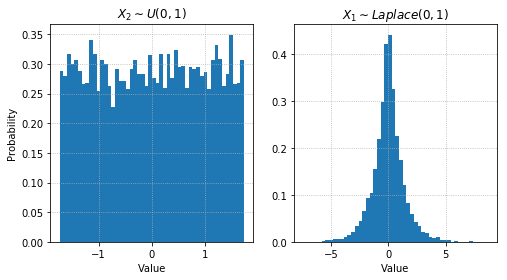

In [5]:
fig = plt.figure(figsize=(8,4))

plt.subplot(121)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.xlabel("Value")
plt.ylabel("Probability")
plt.grid(linestyle="dotted")
plt.title("$X_2 \sim U(0,1)$")
plt.hist(X_1, bins=50, density=True)

plt.subplot(122)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.grid(linestyle="dotted")
plt.title("$X_1 \sim Laplace(0,1)$")
plt.xlabel("Value")
plt.hist(X_2, bins=50, density=True)

plt.show()

In [6]:
mean = np.random.normal(0, 0.5, d)
M = np.random.normal(0, 1, (d, d)) # create random mixing matrix
Y = np.dot(M, X) + mean.reshape((2, 1))# mix initial sources and add mean.

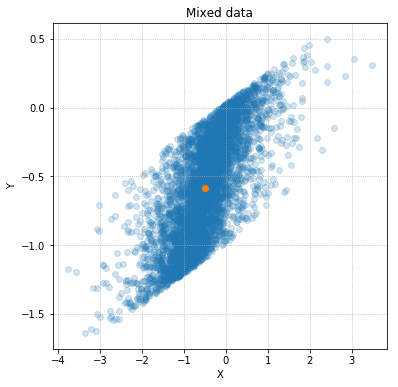

In [7]:
fig = plt.figure(figsize=(6,6))

plt.xlabel("X")
plt.ylabel("Y")
plt.grid(linestyle="dotted")
plt.title("Mixed data")
plt.scatter(Y[0], Y[1], alpha=0.2)
plt.scatter(np.mean(Y.T, axis=0)[0], np.mean(Y.T, axis=0)[1], alpha=1)
plt.show()

In [8]:
unmixing=ICA_NEGENTROPY(Y.T, n_components=2, tol=1e-7)
manualy_separated_dist = unmixing@whiten(Y.T).T

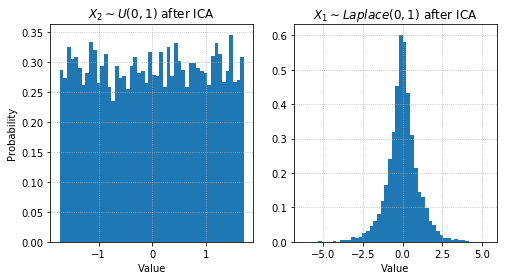

In [9]:
fig = plt.figure(figsize=(8,4))

plt.subplot(121)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.xlabel("Value")
plt.ylabel("Probability")
plt.grid(linestyle="dotted")
plt.title("$X_2 \sim U(0,1)$ after ICA")
plt.hist(manualy_separated_dist[0,:], bins=50, density=True)

plt.subplot(122)
#plt.xlim(-5, 5)
#plt.ylim(-5, 5)
plt.grid(linestyle="dotted")
plt.title("$X_1 \sim Laplace(0,1)$ after ICA")
plt.xlabel("Value")
plt.hist(manualy_separated_dist[1,:], bins=50, density=True)

plt.show()

Cheers! More or less it works.

- #### 2. Time series:

In [10]:
np.random.seed(42) #generate test data
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3.5 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(1.5 * np.pi * time) # sawtooteh

S = np.c_[s1, s2, s3]

S /= S.std(axis=0)
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X_data = np.dot(S, A.T)  # Generate observations

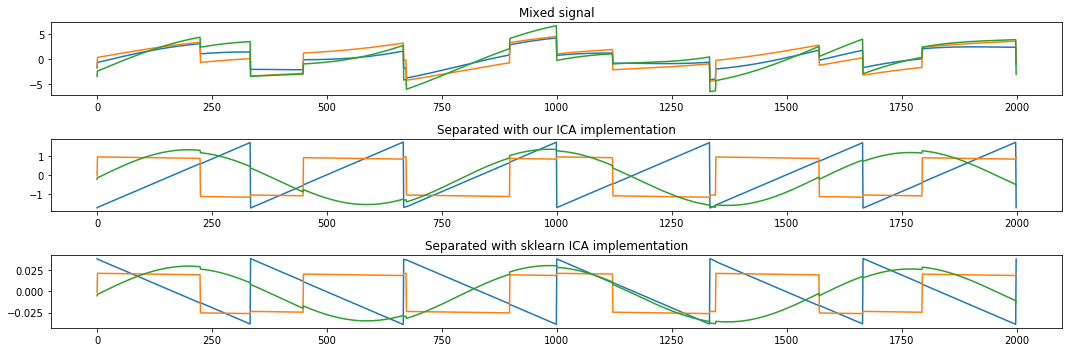

In [11]:
unmixing = ICA_NEGENTROPY(X_data, n_components=3)
manualy_separated = unmixing@whiten(X_data).T

ica = FastICA(n_components=3,algorithm='deflation')
sklearn_separated = ica.fit_transform(X_data)

fig, ax = plt.subplots(3,1, figsize=(15,5))
ax[0].plot(X_data)
ax[0].set_title('Mixed signal')
ax[1].plot(manualy_separated.T)
ax[1].set_title('Separated with our ICA implementation')
ax[2].plot(sklearn_separated)
ax[2].set_title('Separated with sklearn ICA implementation')
plt.tight_layout();

Cheers! More or less it works.

- #### 3. Images:

In [12]:
# Generate test mixed images
shape = (512, 512)
rows, cols = shape

img1 = np.load('camera.npy').flatten()
img2 = np.load('astronaut.npy').flatten()
img3 = np.load('moon.npy').flatten()
img4 = np.load('noise.npy').flatten()

S = np.c_[img1, img2, img3, img4].T

In [13]:
A = np.random.uniform(0.2, 0.8, (4, 4))

# mix data
X = np.dot(A, S)

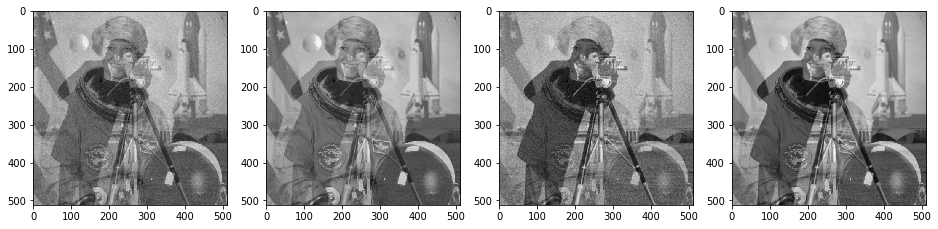

In [14]:
# show images
f, ax = plt.subplots(1, X.shape[0])
f.set_size_inches((16,4))

for i in range(X.shape[0]):
    ax[i].imshow(X[i,:].reshape(rows, cols), cmap=plt.gray())

In [31]:
unmixed_img_mat = ICA_NEGENTROPY(X.T, n_components=4, tol=1e-3, max_iter=4e2, verbose=True, correction=False)

2-100 2-200 2-300 2-400 3-100 3-200 3-300 3-400 

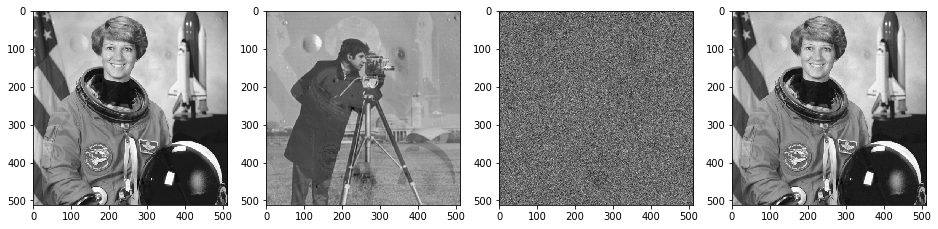

In [32]:
# show images
imgs_separrated = unmixed_img_mat@whiten(X.T).T

f, ax = plt.subplots(1, X.shape[0])
f.set_size_inches((16,4))

for i in range(X.shape[0]):
    ax[i].imshow(imgs_separrated[i,:].reshape(rows, cols), cmap=plt.gray())

###### Conclusion

P.S. Cool homework